In [1]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
from copy import deepcopy as copy

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core.plot import plot_image
from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


[INFO]: starting preprocessing of raw image 'sdR-s-z3-00000559.fits.gz'
[INFO]: using header IMAGETYP = 'object'
[INFO]: exposure time 10.0 (s)
[WARNING]: assuming TRIMSEC = ['[1:2043, 2041:4080]', '[2078:4120, 2041:4080]', '[1:2043, 1:2040]', '[2078:4120, 1:2040]']
[WARNING]: assuming BIASSEC = ['[2044:2060, 2041:4080]', '[2061:2077, 2041:4080]', '[2044:2060, 1:2040]', '[2061:2077, 1:2040]']
[INFO]: using header GAIN = [2.6, 2.65, 2.57, 2.72] (e-/ADU)
[INFO]: median and standard deviation in OS quadrant 1: 2628.60 +/- 4.49 (e-)
[INFO]: median and standard deviation in OS quadrant 2: 2687.10 +/- 4.97 (e-)
[INFO]: median and standard deviation in OS quadrant 3: 2603.41 +/- 4.68 (e-)
[INFO]: median and standard deviation in OS quadrant 4: 2752.64 +/- 5.51 (e-)
[INFO]: using header RDNOISE = [3.6, 3.6, 3.4, 3.6] (e-)
[INFO]: flipping along X-axis
[INFO]: updating header with per quadrant stats
[INFO]: building pixel mask
[INFO]: 12244 (0.073 %) pixels masked
[INFO]: writing output image t

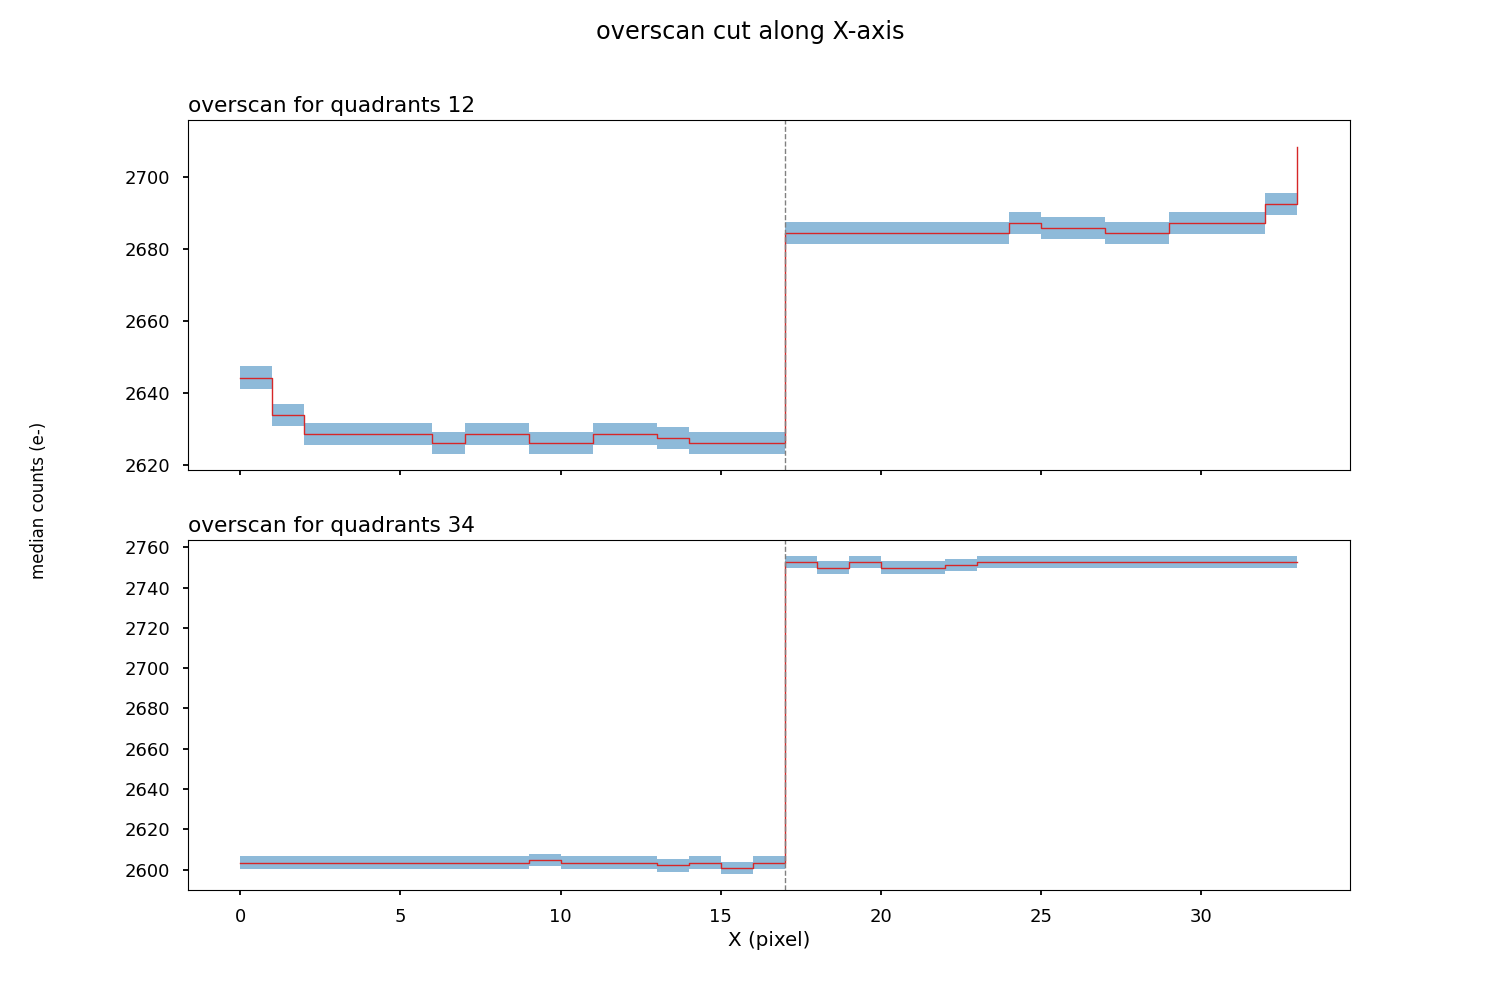

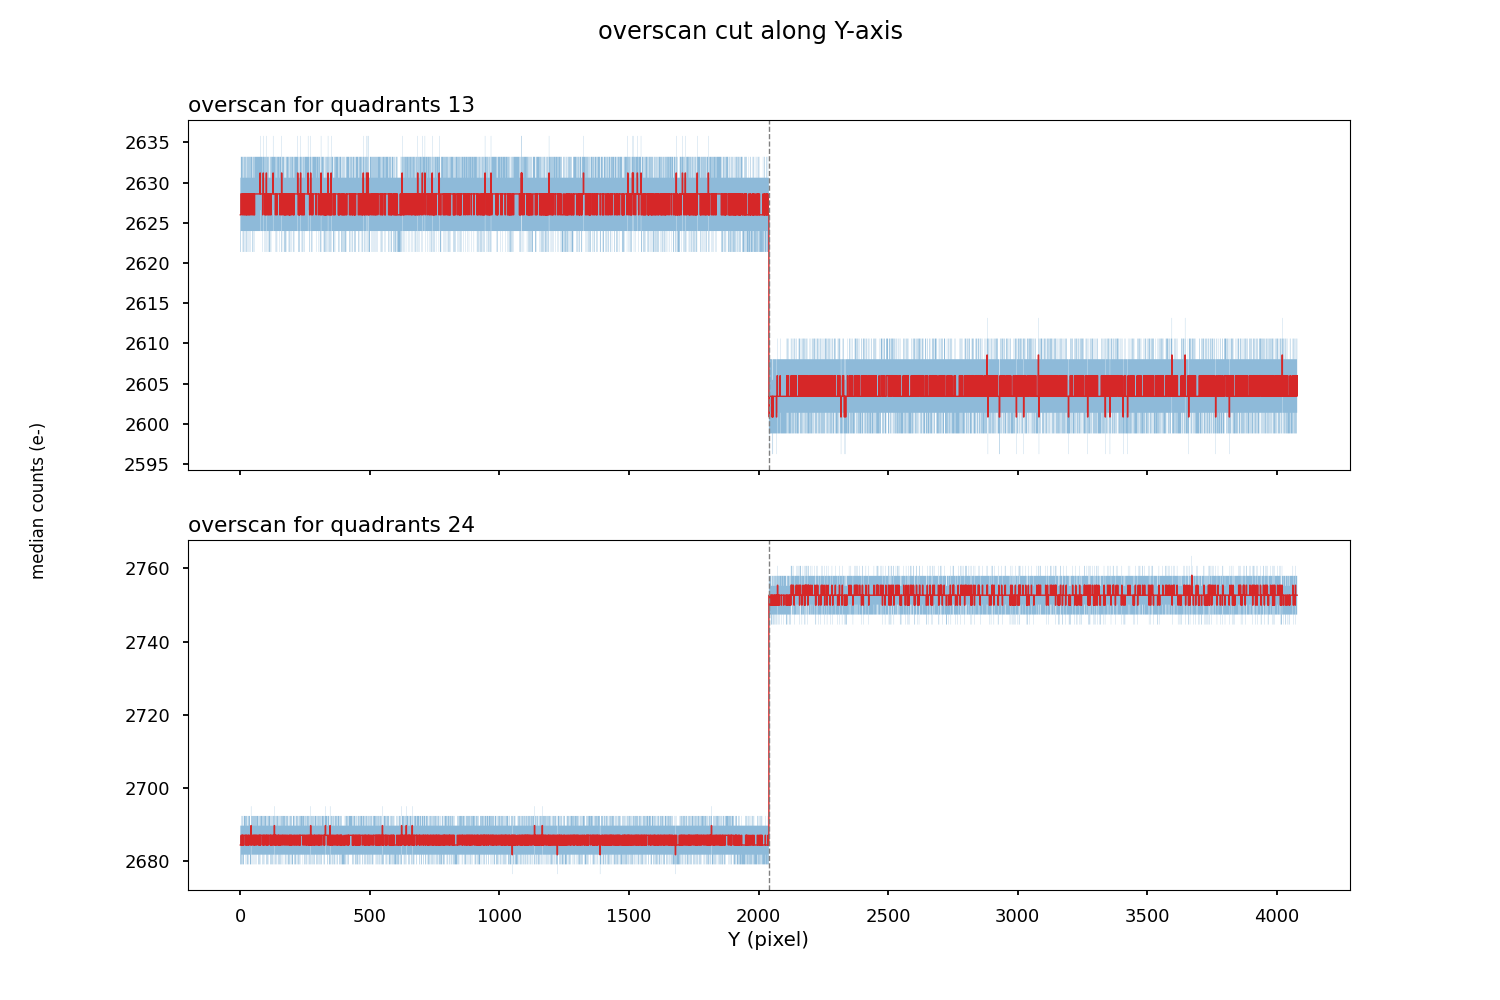

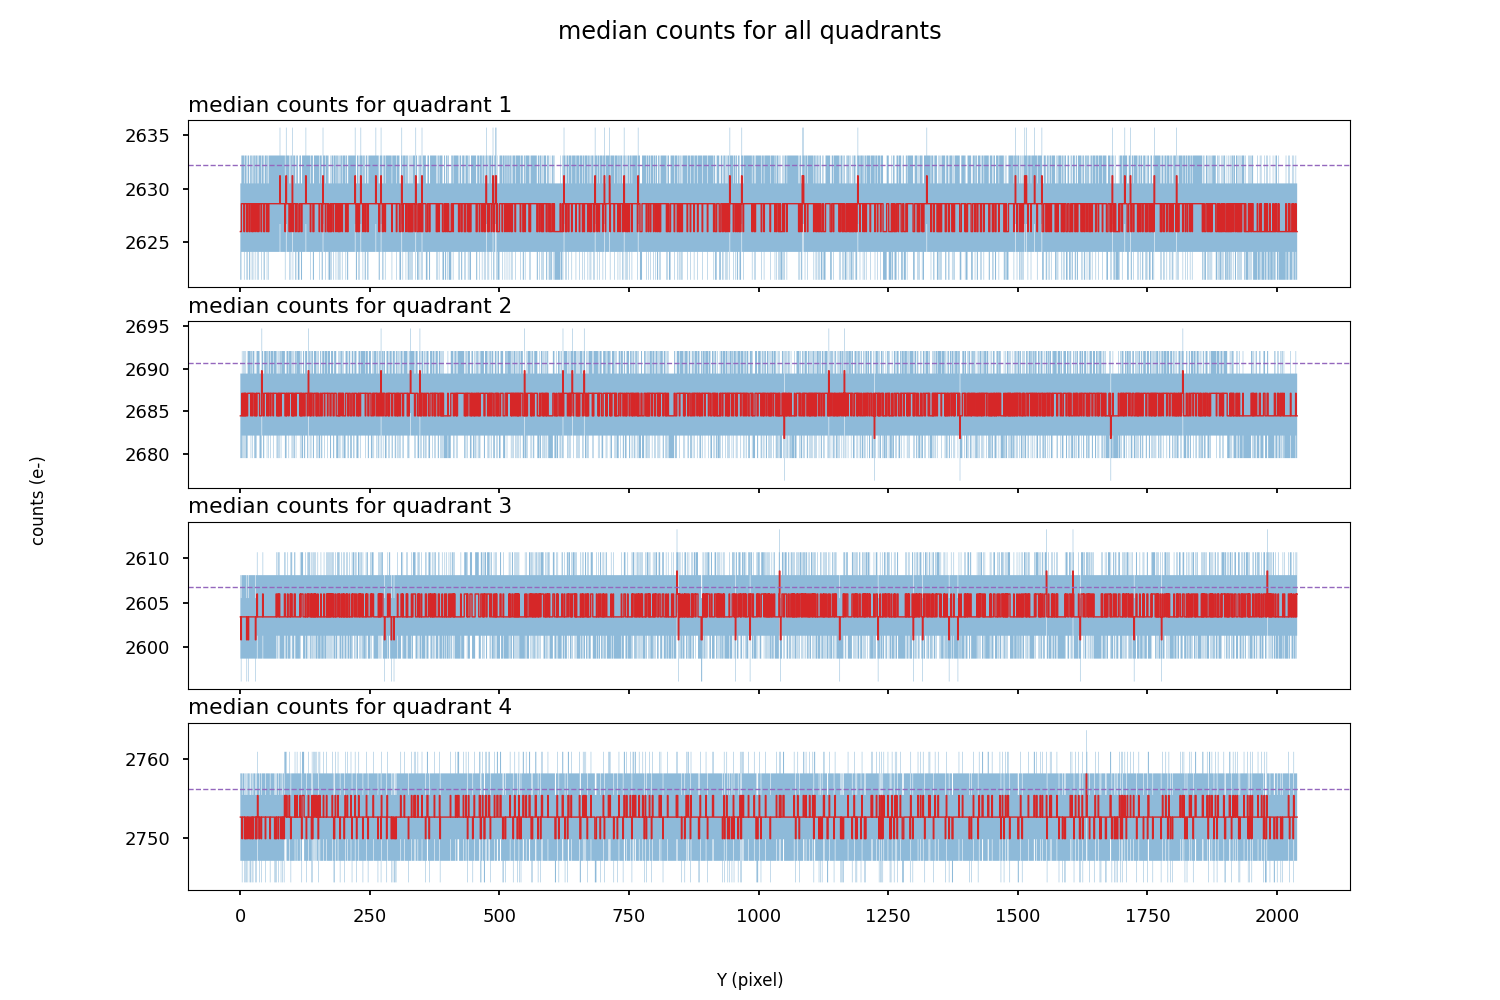

In [10]:
# frame = frames_table.query("expnum=='00000680' & camera=='r2'").iloc[0]
# frame = frames_table.query("expnum=='00000562' & camera=='r3'").iloc[0]
frame = frames_table.query("expnum=='00000559' & camera=='z3'").iloc[0]
frame_path = frame.path
frame_camera, frame_expnum = frame.camera, frame.expnum

imageMethod.preprocRawFrame_drp(
    in_image=frame_path,
    out_image=out_main_path.format(kind=f"p{frame.imagetyp}", camera=frame_camera, expnum=frame_expnum),
    in_mask=out_calib_path.format(mjd="super", kind="mask", camera=frame_camera, exptime="x"),
    display_plots="1"
)

[INFO]: target frame parameters: MJD = 60039, exptime = 10.0, camera = z3
[INFO]: using bias calibration frame './data/lvm-super-mbias-z3-0.fits'
[INFO]: using dark calibration frame './data/lvm-super-mdark-z3-5.fits'
[WARNING]: scaling-up master dark frame
[INFO]: subtracting master bias
[INFO]: calculating Poisson errors per quadrant
[INFO]: median error in quadrant 1: 138.09 (e-/s)
[INFO]: median error in quadrant 2: 140.12 (e-/s)
[INFO]: median error in quadrant 3: 129.97 (e-/s)
[INFO]: median error in quadrant 4: 137.90 (e-/s)
[INFO]: subtracting master dark
[INFO]: propagating pixel mask
[INFO]: rejecting cosmic rays
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
[INFO]: found cosmic ray 0 pixels
[INFO]: refining pixel mask with median_box = (1, 15)
[INFO]: saving detrended image at './data/lvm-cobject-z3-00000559.fits'
[INFO]: plotting results
[WARNING]: This figure includes Axes that are not compatible with tight_layout, so re

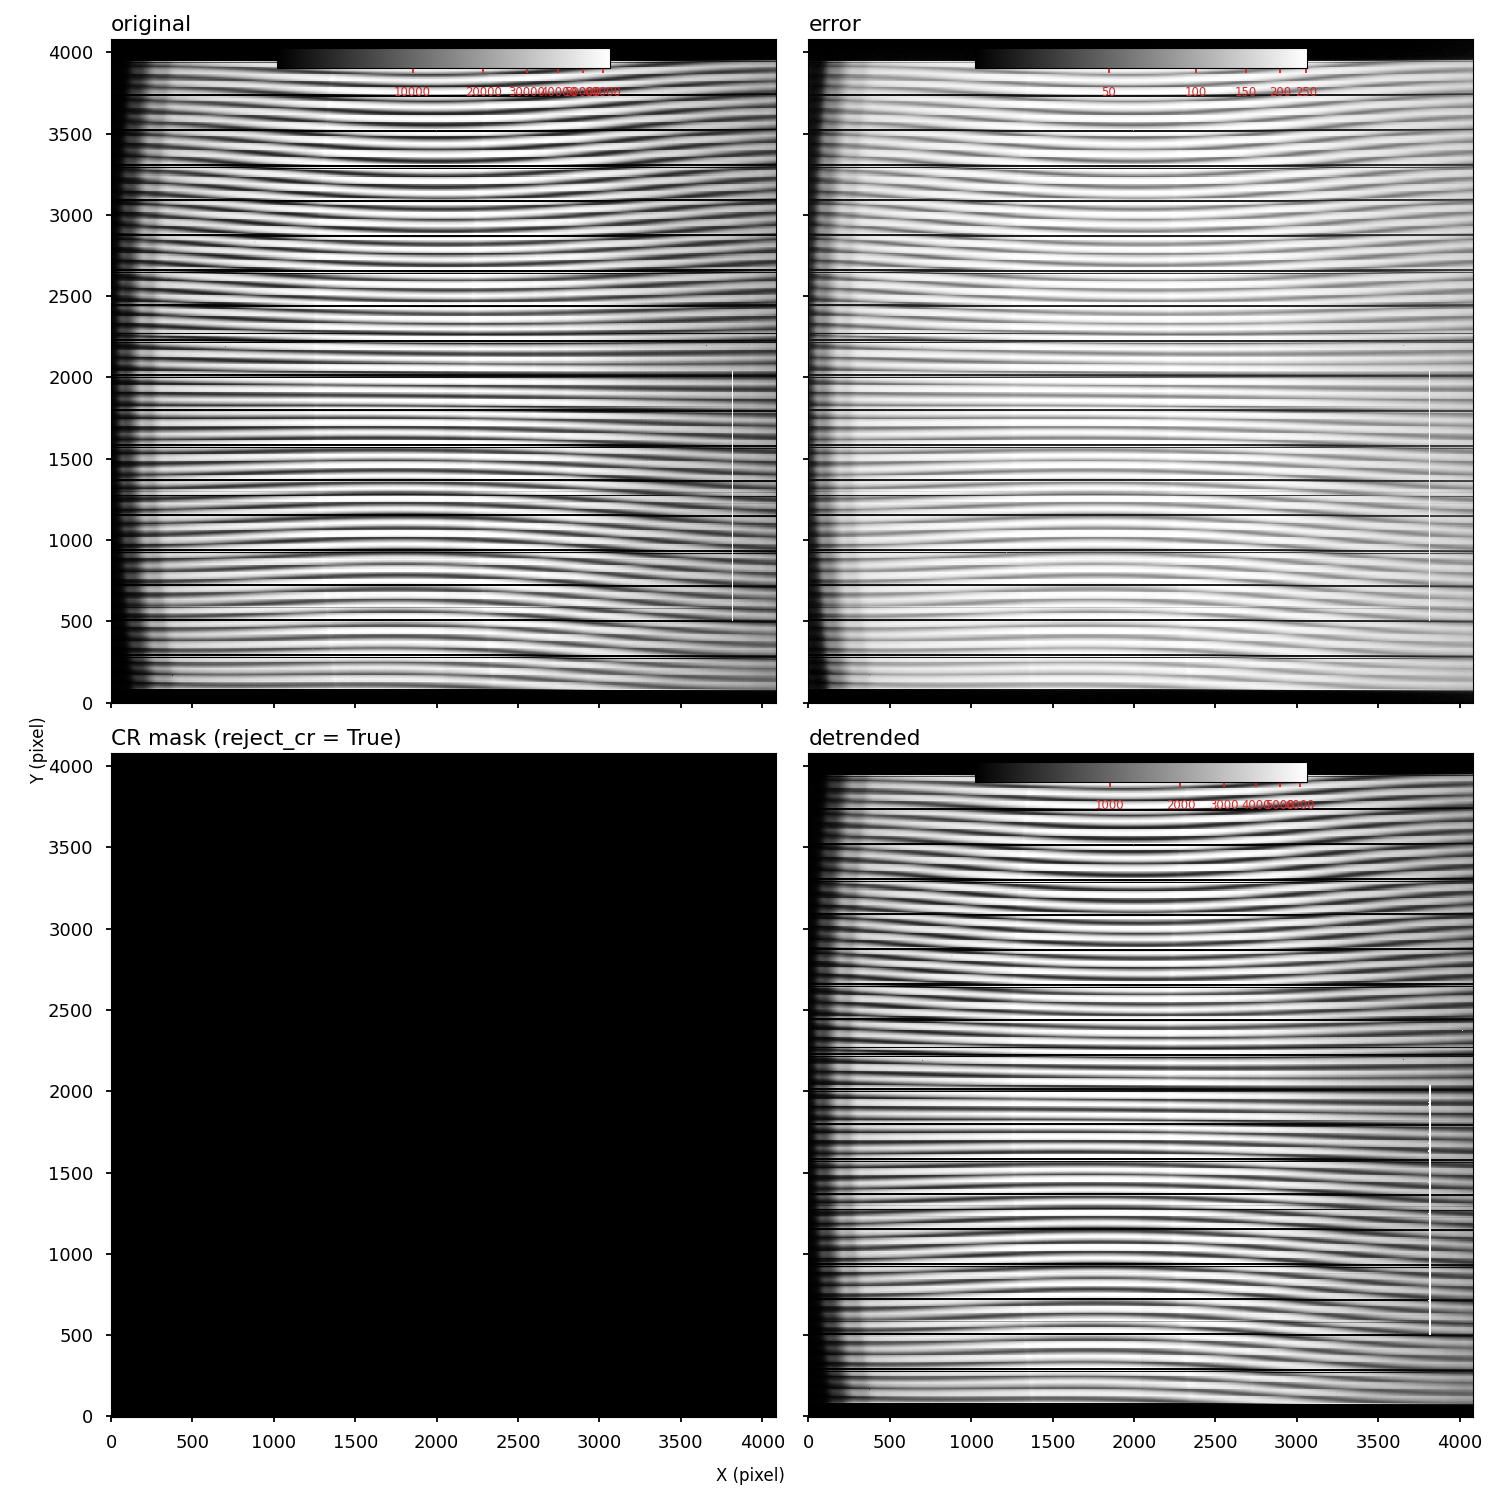

In [11]:
imageMethod.detrendFrame_drp(
    in_image=out_main_path.format(kind=f"p{frame.imagetyp}", camera=frame_camera, expnum=frame_expnum),
    out_image=out_main_path.format(kind=f"c{frame.imagetyp}", camera=frame_camera, expnum=frame_expnum),
    in_bias=out_calib_path.format(mjd="super", kind="mbias", camera=frame_camera, exptime=0),
    in_dark=out_calib_path.format(mjd="super", kind="mdark", camera=frame_camera, exptime=5),
    reject_cr="1", display_plots="1"
)

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
1357
[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


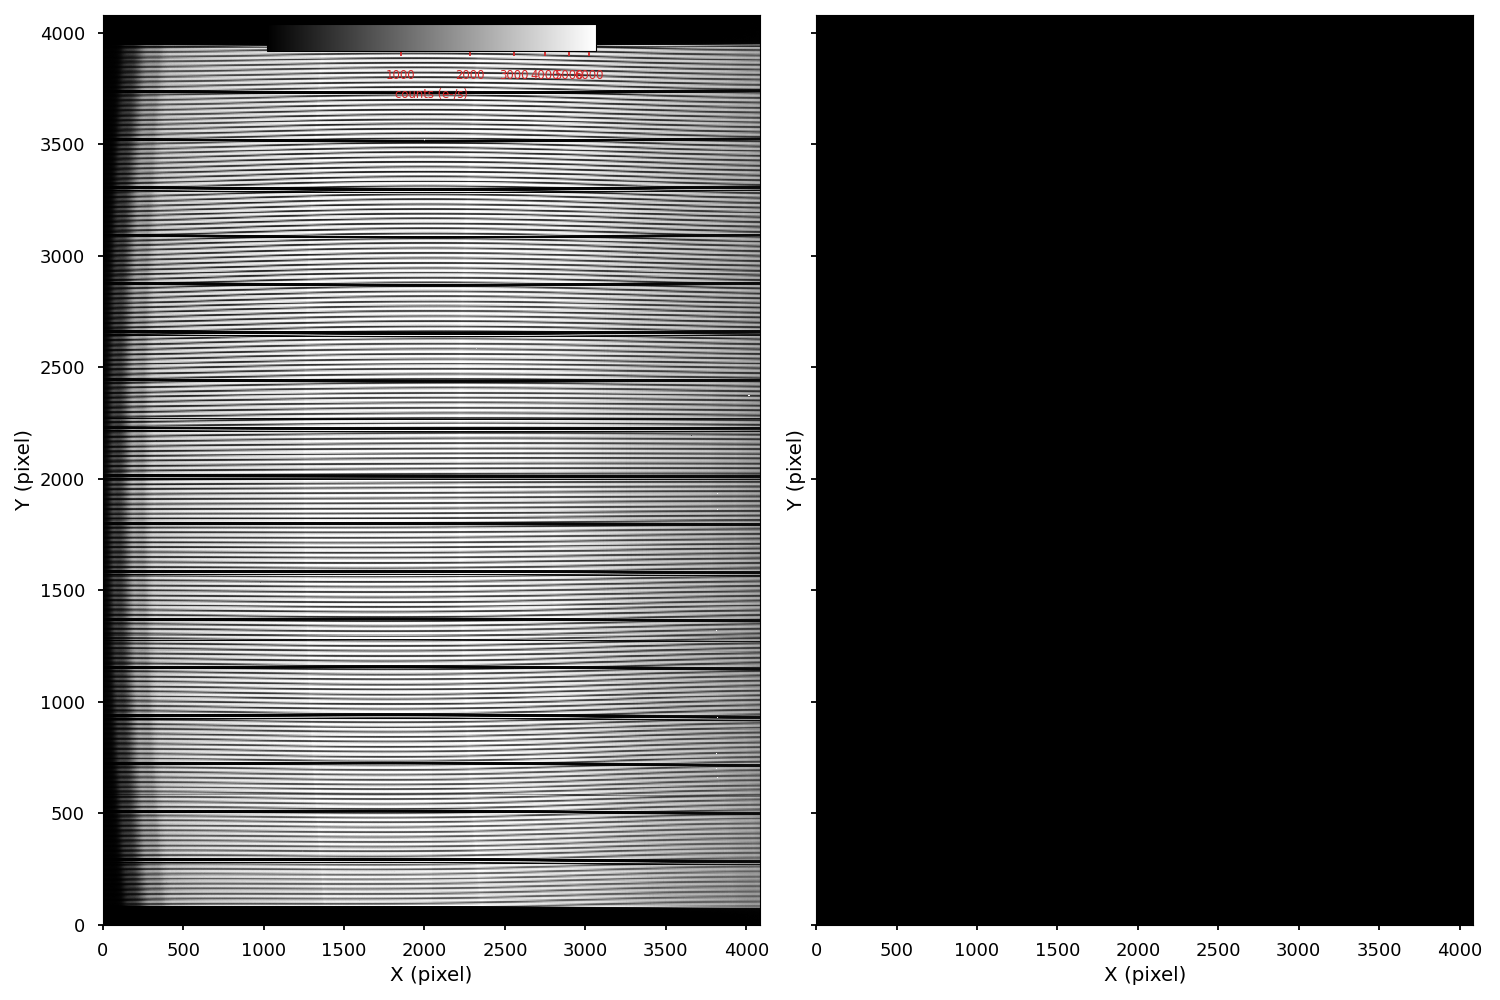

In [12]:
from astropy.nddata import CCDData
from ccdproc import cosmicray_lacosmic

detrended_image = image.loadImage(out_main_path.format(kind=f"c{frame.imagetyp}", camera=frame_camera, expnum=frame_expnum))


ccd = CCDData(
    detrended_image._data*detrended_image._header["EXPTIME"],
    uncertainty=detrended_image._error*detrended_image._header["EXPTIME"],
    unit=u.electron,
    mask=detrended_image._mask,
)
clean_ccd = cosmicray_lacosmic(ccd, sigclip=30.0, objlim=np.percentile(detrended_image._data, q=99.9))
cr_mask = clean_ccd.mask
cr_mask[detrended_image._mask] = False
clean_image = image.Image(data=clean_ccd.data, mask=cr_mask)
# update image with cosmic ray mask
# detrended_image.setData(mask=(detrended_image._mask | clean_image._mask))

print(cr_mask.sum())

fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)
plot_image(detrended_image, ax=axs[0])
plot_image(clean_image, ax=axs[1], extension="mask")
fig.tight_layout()

In [45]:
# cr_mask = detrended_image.createCosmicMask()
# clean_image = image.Image(data=detrended_image._data, mask=cr_mask)

# print(cr_mask.sum())

# fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)
# plot_image(detrended_image, ax=axs[0])
# plot_image(clean_image, ax=axs[1], extension="mask")
# fig.tight_layout()

[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


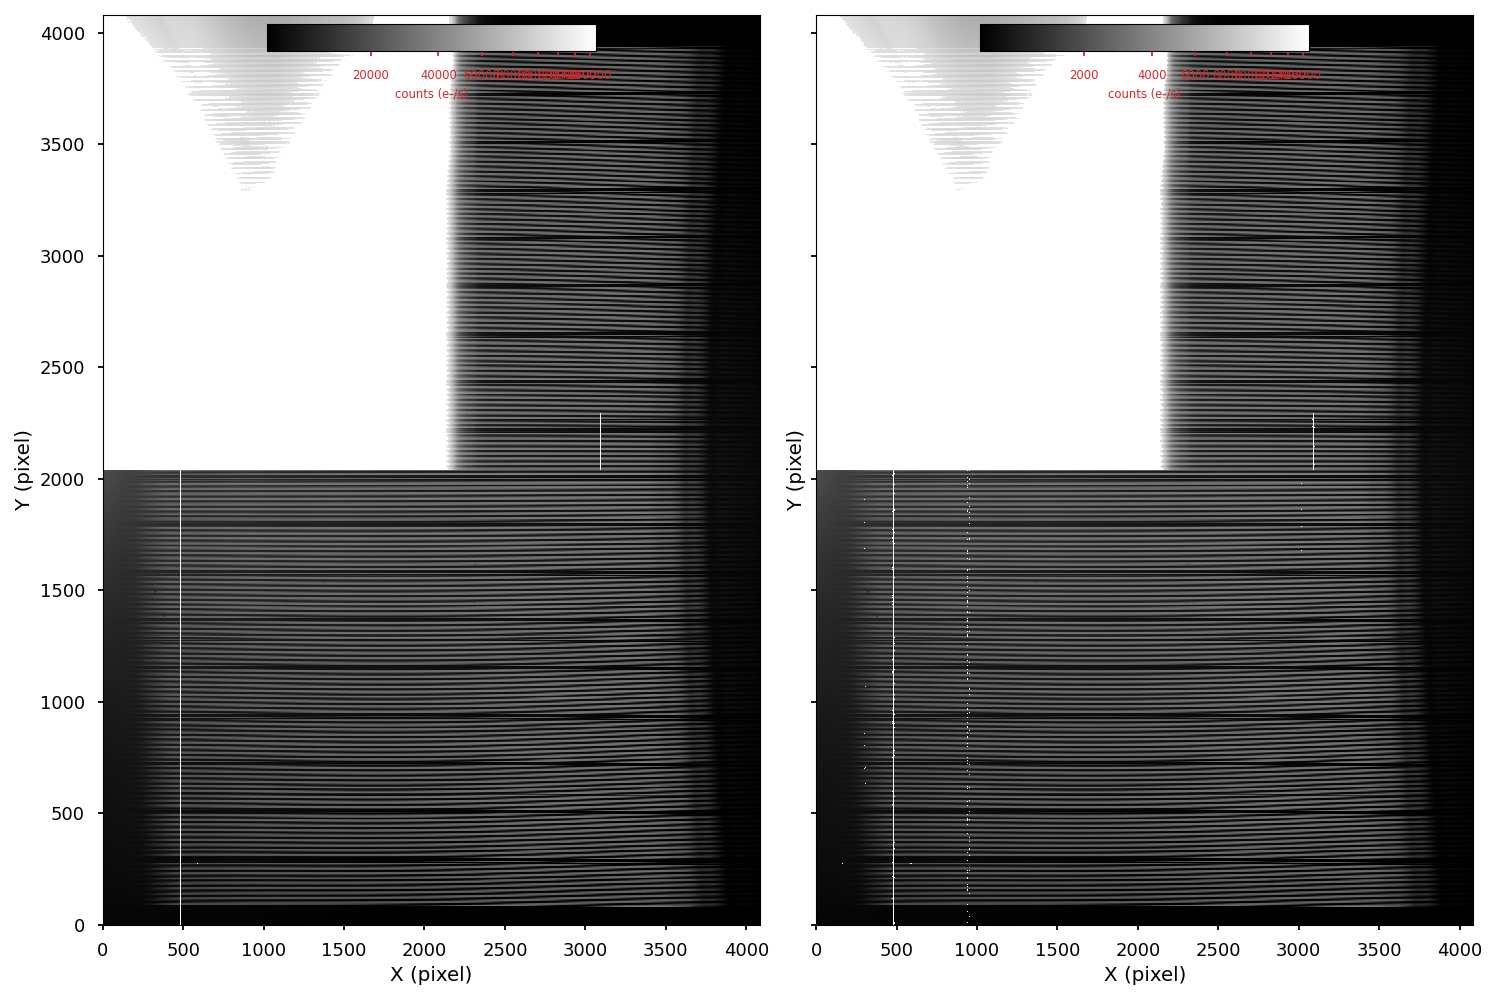

In [46]:
pre = image.loadImage(out_main_path.format(kind=f"p{frame.imagetyp}", camera=frame_camera, expnum=frame_expnum))
img = image.loadImage(out_main_path.format(kind=f"c{frame.imagetyp}", camera=frame_camera, expnum=frame_expnum))

fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)
plot_image(pre, ax=axs[0])
plot_image(img, ax=axs[1])
fig.tight_layout()

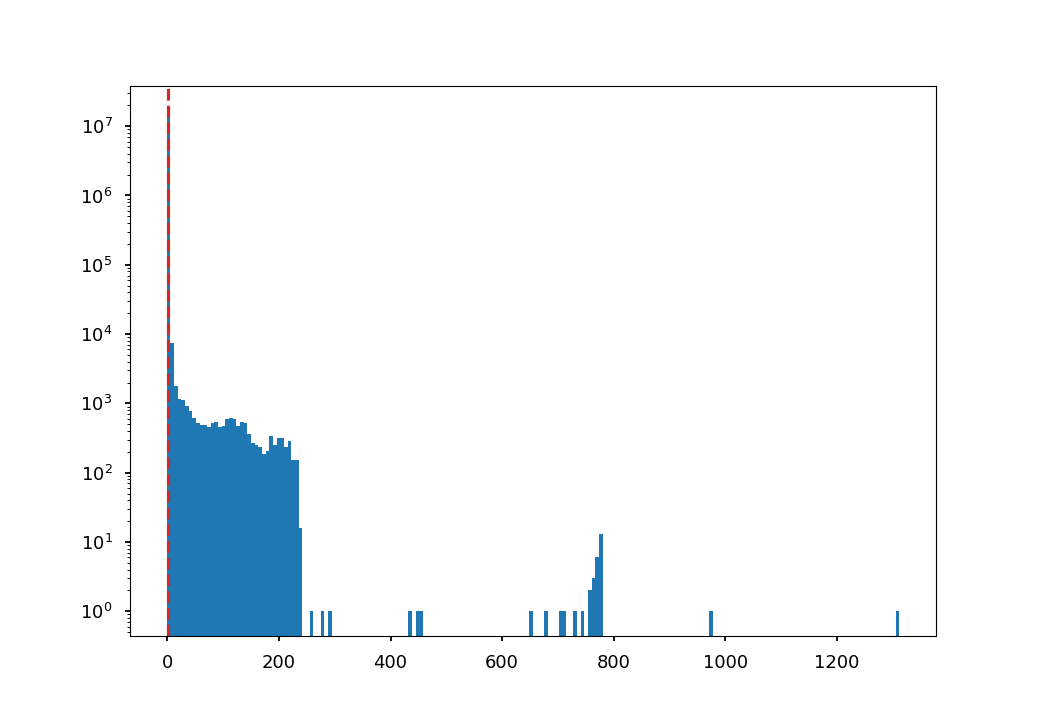

In [25]:
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
from scipy.stats import sigmaclip

img_array = np.ma.masked_array(img._data, mask=img._mask, fill_value=np.nan)

plt.figure()
plt.hist(img_array.filled().flatten(), bins=200)
plt.axvline(np.nanpercentile(img_array.filled(np.nan), 99.5), ls="--", color="tab:red")
# plt.xscale("log")
plt.yscale("log")

[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


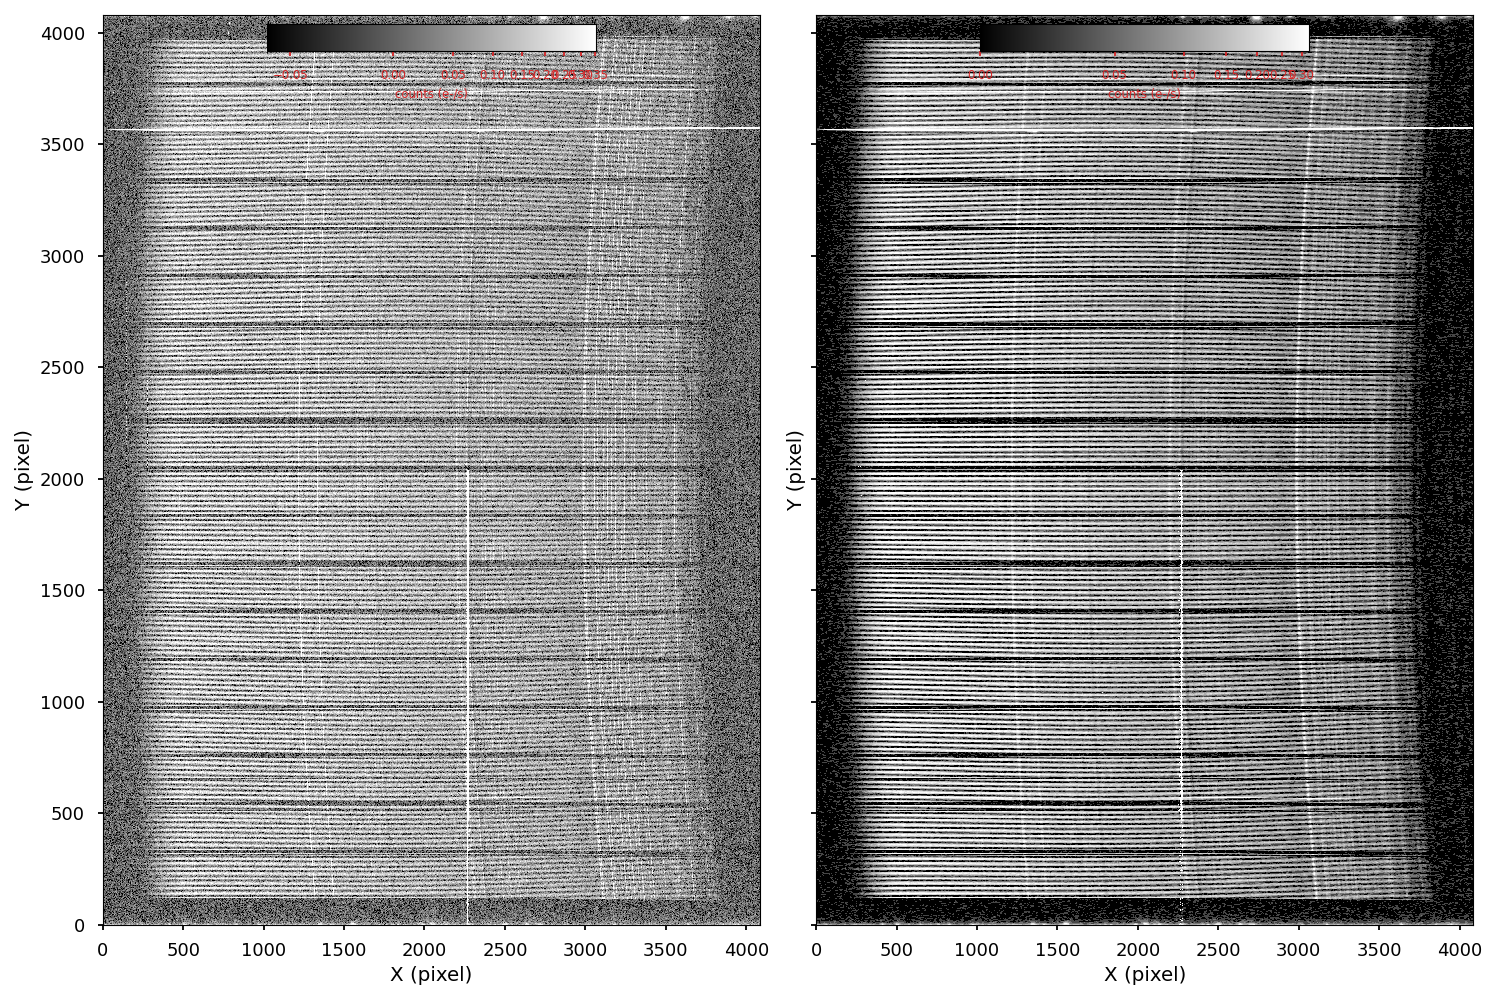

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)

plot_image(img, ax=axs[0], colorbar=True, use_mask=True)

median_img = img.medianImg(size=(1,15), use_mask=True)
plot_image(median_img, ax=axs[1], colorbar=True, use_mask=True)
fig.tight_layout()

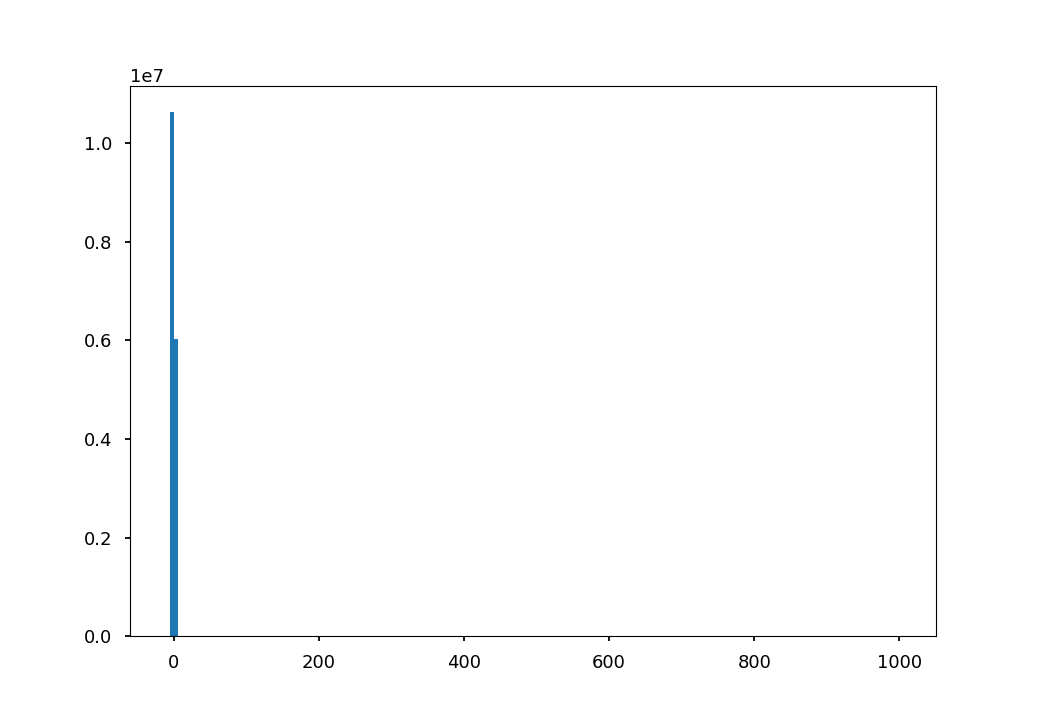

In [27]:
plt.figure()
plt.hist(median_img._data.flatten(), bins=200, range=(-10, 1000));

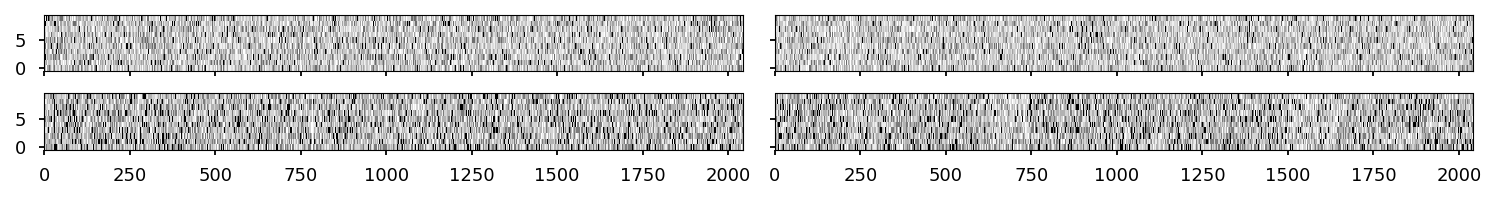

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15,2), sharex=True, sharey=True)
axs = axs.flatten()
plot_image(img.getSection(img._header["AMP1 TRIMSEC"]).getSection("[1:2043, 61:70]"), ax=axs[0], labels=False, colorbar=False)
plot_image(img.getSection(img._header["AMP2 TRIMSEC"]).getSection("[1:2043, 61:70]"), ax=axs[1], labels=False, colorbar=False)
plot_image(img.getSection(img._header["AMP3 TRIMSEC"]).getSection("[1:2043, 1991:2000]"), ax=axs[2], labels=False, colorbar=False)
plot_image(img.getSection(img._header["AMP4 TRIMSEC"]).getSection("[1:2043, 1991:2000]"), ax=axs[3], labels=False, colorbar=False)

fig.tight_layout()

[WARNING]: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect. (UserWarning)


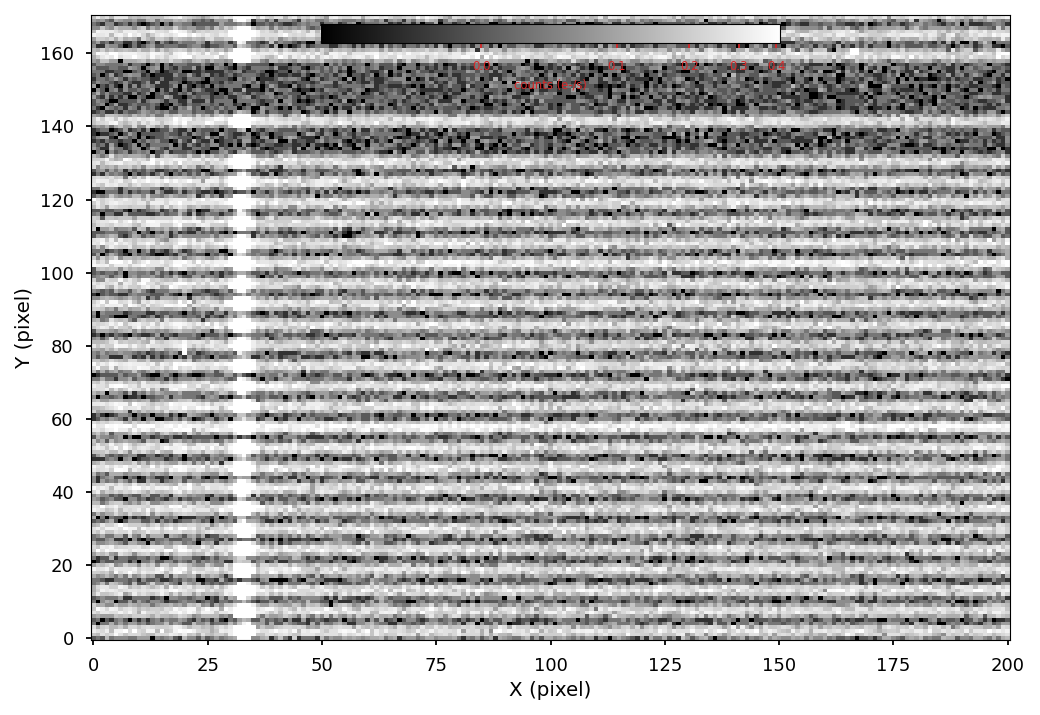

In [29]:
# sub_img = img.getSection("[1300:1400, 1040:1100]")
sub_img = img.getSection("[1300:1500, 1900:2070]")

plt.figure()
# norm = simple_norm(sub_img._data, stretch="log", clip=True)
# plt.imshow(sub_img._data, origin="lower", norm=norm)
plot_image(sub_img, ax=plt.gca())
plt.tight_layout()

In [14]:
# sub_img_copy = copy(sub_img)
# cr_mask = sub_img_copy.createCosmicMask(iter=1, sigma_det=2, flim=1.1, parallel=1)

# plt.figure(figsize=(10,10))
# plt.imshow(cr_mask, origin="lower")
# plt.tight_layout()

In [15]:
# norm = simple_norm(img._data, stretch="log", clip=True)
# fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)
# axs[0].imshow(sub_img._data, origin="lower", norm=norm)
# axs[1].imshow(sub_img_copy._data, origin="lower", norm=norm)
# fig.tight_layout()